# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple Diffusion Model following the steps of in this video
During the learning process i'll take some notes and make some modifications in the code.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


# The dataset

As dataset we use the EuroSAT Dataset[link] (StandordCars in the original), which consists of around 27000 geo spatial images taken by the Sentinel-2 satellite. 



Dataset size: 27000 samples


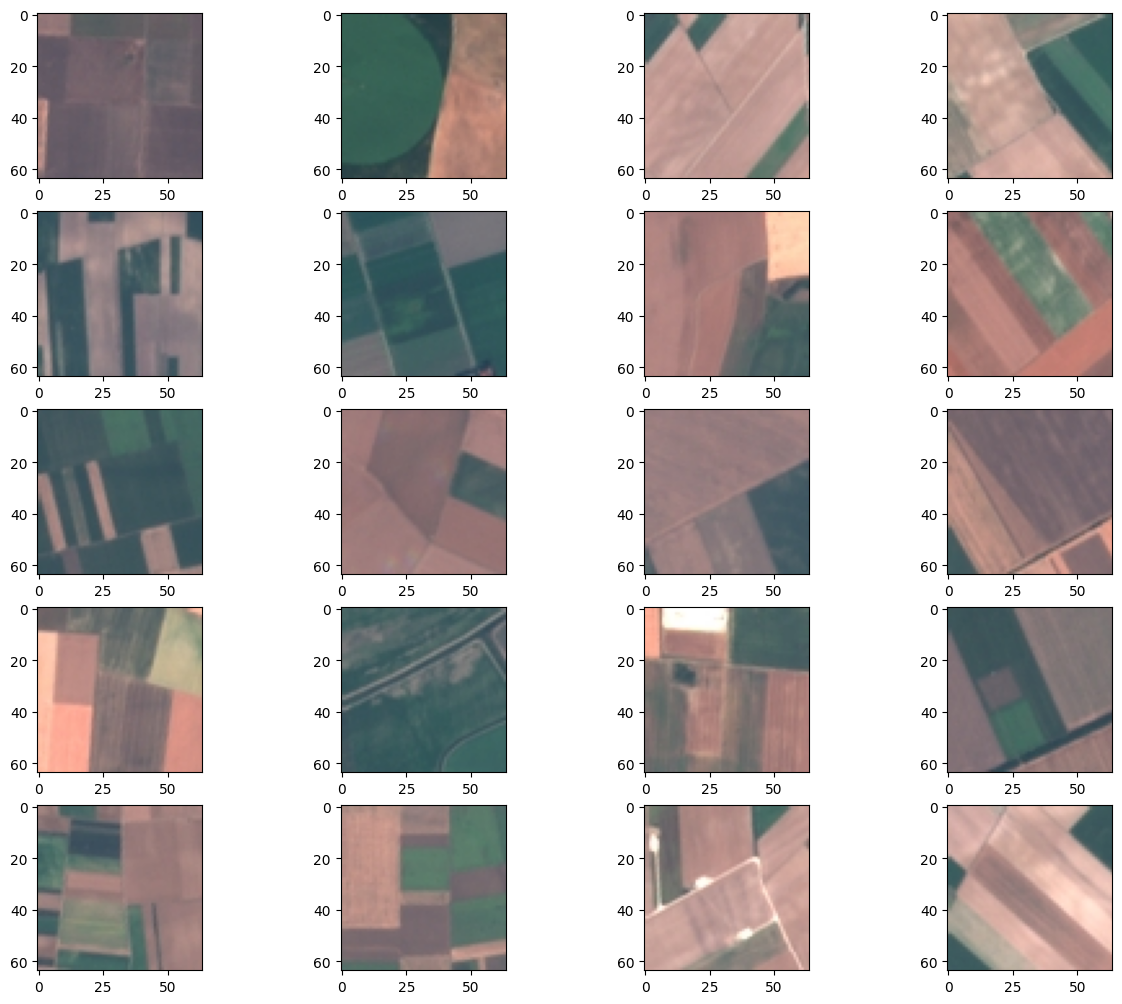

In [14]:
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        #print(img[0].size)
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.EuroSAT(root=".", download=True)
print(f"Dataset size: {len(data)} samples")
show_images(data)


# The Diffusion Model

## Step 1: The forward process = Noising = Noise scheduler


The first step in diffusion models involves constructing progressively noisier versions of our input images.
Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually. 

In this implementation, we use a linear variance schedule due to its simplicity and interpretability.
More advanced approaches like cosine scheduling offer smoother noise transitions that can improve model performance.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No ML stuff in this forward step

In [15]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Generates a linearly spaced schedule for beta values, which control the noise added at each timestep.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Applies forward diffusion to an image by adding noise at a given timestamp.

    Parameters
    ----------
    x_0 : Tensor
        The original image.
    t : int
        The diffusion timestep.
    device : str, optional
        The device to use for computation, either "cpu" or "cuda" (default is "cpu").

    Returns
    -------
    tuple
        A tuple containing the noisy image tensor and the noise tensor.
    """
    noise = torch.randn_like(x_0)  # Generate Gaussian noise of the same shape as the image
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # Compute the noisy image using the reparameterization trick: mean + variance
    noisy_image = sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + \
                  sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
    
    return noisy_image, noise.to(device)


# Define beta schedule (T is the total number of timesteps in the diffusion process)
T = 300  # Number of diffusion steps
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)  # Cumulative product of alphas
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # Shifted version with padding
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)  # Square root of inverse alphas
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)  # Square root of cumulative product of alphas
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)  # Square root of (1 - cumulative product)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)  # Variance used in reverse diffusion


In [16]:
#Let's test it on our dataset ...

from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),# Resize to 64x64
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.EuroSAT(root=".", download=True, 
                                         transform=data_transform)

    return torch.utils.data.ConcatDataset([data])


def show_tensor_image(image, save=False, save_path=None):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]

    img = reverse_transforms(image)
    plt.imshow(img)

    # Save the image if requested
    if save:
        if save_path:
            img.save(save_path)
        else:
            raise ValueError("save_path must be provided when save is True")

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

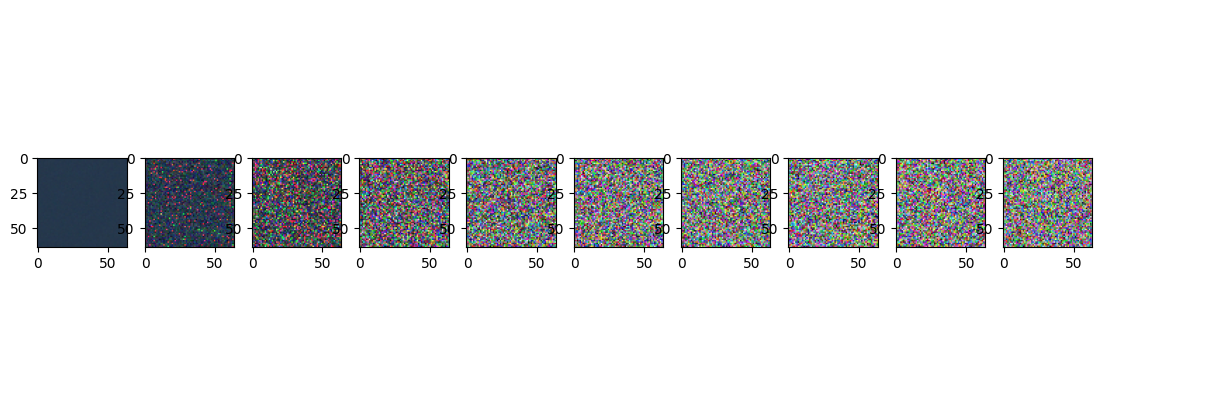

In [17]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,5))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: The backward process = Denoising = U-Net

For a great introduction to UNets, have a look at this post: https://amaarora.github.io/posts/2020-09-13-unet.html

### Key Concepts of U-Net
1. **Encoder-Decoder Structure**

    * Encoder (Downsampling Path): This part of the network reduces the spatial dimensions of the input image while increasing the number of feature channels. It captures the context of the image.

    * Decoder (Upsampling Path): This part of the network increases the spatial dimensions back to the original image size while reducing the number of feature channels. It helps in precise localization.

2. **Skip Connections**
One of the defining features of U-Net is the use of skip connections. These connections link corresponding layers in the encoder and decoder paths. They help the network to retain fine-grained spatial information that might be lost during the downsampling process, which is crucial for accurate segmentation.

3. **Convolutional Blocks**
Each block in U-Net typically consists of:

    * Convolutional Layers: These layers apply a convolution operation to the input, followed by an activation function (e.g., ReLU).
    
    * Batch Normalization: This helps in stabilizing and accelerating the training process.
    
    * Pooling/Upconvolution: In the encoder, pooling layers (e.g., max pooling) are used to downsample the feature maps. In the decoder,    upconvolution (transposed convolution) is used to upsample the feature maps.

4. **Time Embeddings**
In some variants of U-Net, such as those used in diffusion models, time embeddings are introduced to condition the network on a specific timestep. Time plays a vital role as it indicates the noise level added to or removed from an image. The model needs this temporal context to:
    * Understand which step of the diffusion process it's currently in
    
    * Determine how much noise to add or remove
    
    * Adjust its behavior based on the current timestep in the forward or reverse process

The time embedding is generated using sinusoidal functions, similar to positional encodings in transformers. Once generated, this time embedding is added to the feature vectors at each block of the U-Net. This simple addition operation allows the network to process the image features while being aware of the current noise level/timestep

**Key Takeaways**:
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [18]:
from torch import nn
import math


class Block(nn.Module):
    """
    A building block for the U-Net model, supporting both downsampling and upsampling.
    Think of it as one "step" in the U shape of the network.
    
    Parameters
    ----------
    in_ch : int
        Number of input channels.
    out_ch : int
        Number of output channels.
    time_emb_dim : int
        Dimension of the time embedding vector.
    up : bool, optional
        If True, performs upsampling, otherwise performs downsampling (default).
    """
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        
        if up:#Upsampling block (right side of the U)
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:#Downsampling block (left side of the U)
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        # common layers for up and down blocks
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        """
        Forward pass of the block.
        
        Parameters
        ----------
        x : torch.Tensor
            Input tensor.
        t : torch.Tensor
            Time embedding tensor.
        
        Returns
        -------
        torch.Tensor
            Transformed tensor.
        """
        # 1st Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Add two dimensions to match image dimensions (batch, channel, height, width)
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time information to features (key for diffusion!!!)
        h = h + time_emb
        # 2nd Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    """
    Generates sinusoidal position embeddings for time steps.
    This helps the model understand at which step of the diffusion process we are.

    Parameters
    ----------
    dim : int
        Dimension of the embedding vector.
    """

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        # Combine sine and cosine embeddings
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    U shape:    first decreases resolution and increases channels (down),
                then increases resolution and decreases channels (up).
    """
    def __init__(self):
        super().__init__()
        image_channels = 3 #rgb
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 #rgb
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        """
        Forward pass of the U-Net.
        
        Parameters
        ----------
        x : torch.Tensor
            Input tensor (image with noise).
        timestep : torch.Tensor
            Timestep tensor for conditioning.
        
        Returns
        -------
        torch.Tensor
            Denoised output tensor.
        """
                
        # Convert timestep to embedding
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet stores intermediate outputs for skip connections
        residual_inputs = []

        # Downsampling path
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)# Store for skip connection

        # Upsampling path
        for up in self.ups:
            # Get the skip connection from the corresponding level
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

## Step 3: The loss

Loss function will measure how well our model predicts the noise that was added to the image, guiding the network to learn the denoising process.
The current implementation uses L1 loss (Mean Absolute Error), which is good for its robustness to outliers compared to L2. Here are other popular choices:

*   **1. L1 Loss (Mean Absolute Error)**
```python
F.l1_loss(noise, noise_pred)
```

L1 Loss, also known as Mean Absolute Error (MAE), is a fundamental loss function used in diffusion models. It calculates the absolute difference between the predicted and actual values


*   **2. L2 Loss (Mean Squared Error)**
```python
F.mse_loss(noise, noise_pred)
```

L2 loss penalizes larger errors more heavily than L1, which can help the model focus on reducing major artifacts. However, it's more    sensitive to outliers and might cause blurrier results since it tends to average out solutions.

*   **3. Huber Loss**
```python
F.smooth_l1_loss(noise, noise_pred, beta=1.0)
```

This is like L2 for small errors and L1 for large ones, giving you the best of both worlds. It's less sensitive to outliers than L2 but     still provides stronger gradients than L1 for small errors.

*   **4. Hybrid Loss**
```python
def hybrid_loss(noise, noise_pred, alpha=0.8):
    l1 = F.l1_loss(noise, noise_pred)
    l2 = F.mse_loss(noise, noise_pred)
    return alpha * l1 + (1 - alpha) * l2
```

The choice of loss function depends on your specific use case:
    For preserving sharp features and details: L1 loss is often preferred
    For faster convergence: L2 loss can work better due to stronger gradients
    For a robust general solution: Huber loss is a great compromise

Starting with L1 or Huber loss is recommended, as they tend to be more robust while still giving good results.

In [19]:
def get_loss(model, x_0, t):
    """
    Computes the L1 loss between the predicted noise and the actual noise.

    Parameters
    ----------
    model : nn.Module
        The U-Net model used for denoising.
    x_0 : torch.Tensor
        The original image.
    t : torch.Tensor
        The diffusion timestep.
    device : str, optional
        The device to use for computation (default is "cpu").

    Returns
    -------
    torch.Tensor
        The computed L1 loss.
    """
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Step 4: Sampling

The sampling process allows us to visualize how well our model is learning to denoise images during training. By starting with random noise and applying our denoising model step by step, we can see the generation progress.

- Without adding the @torch.no_grad() decorator we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation 
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [20]:
import os
# Ensure the directory for saving images exists
os.makedirs("samples_images", exist_ok=True)

@torch.no_grad()
def sample_timestep(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Applies one denoising step in the diffusion process.
    
    Parameters:
    x (torch.Tensor): The current noisy image tensor.
    t (torch.Tensor): The current timestep tensor.
    
    Returns:
    torch.Tensor: The denoised image tensor for the next step.
    """
    # Get noise schedule parameters for this timestep
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Predict noise and compute mean of denoised image
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean  # No more noise to add at the final step
    else:
        noise = torch.randn_like(x)  # Sample new noise
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(epoch: int):
    """
    Generates an image by iteratively denoising a random tensor.
    Saves the least noisy image (final denoised version) in 'samples_images/'.
    
    Parameters:
    epoch (int): The current epoch number (used in the saved filename).
    """
    # Initialize a random noise image
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    print(device)
    plt.figure(figsize=(9, 6))
    plt.axis('off')
    num_images = 10  # Number of intermediate images to display
    stepsize = int(T / num_images)
    
    for i in range(T-1, -1, -1):  # Reverse sampling process
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        #img = torch.clamp(img, -1.0, 1.0)  # Ensure pixel values remain in valid range
        
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            show_tensor_image(img.detach().cpu())
    
    plt.show()
    
    # Save the first fully denoised image (least noisy)
    save_path = os.path.join("samples_images", f"sample_epoch_{epoch}.png")
    show_tensor_image(img.detach().cpu(), save=True, save_path=save_path)
     

## Step 5: Training

This script sets up and trains a U-Net model for a diffusion-based generative task using PyTorch. It includes essential components such as optimizer setup, training loop, and logging with TensorBoardX.  

In each epoch, the model follows these steps:  

1. **Noise Injection:** A batch of images is selected, and a random amount of noise is applied to each image.  
2. **Denoising Attempt:** The model processes the noisy images, attempting to reconstruct the original clean images.  
3. **Loss Calculation:** The difference between the original images and the model’s reconstructed outputs is computed as the loss.  
4. **Weight Updates:** The model adjusts its parameters through backpropagation to improve its ability to remove noise.  

By repeating this process over multiple iterations, the model gradually learns to generate new images from random noise.  

**Added Features to the original notebook**  

- **Checkpointing:** The script saves model checkpoints, allowing training to be resumed from the best-performing state if needed.  
- **TensorBoard Integration:** Loss values are logged in TensorBoard, providing a visual representation of the training progress.  


In [21]:
#First checkout if our gpu is ready to work

if torch.cuda.is_available():
    print("cuda availible :) !")
    print(torch.cuda.get_device_name())
else:
    print("cuda not availible :( !")

# Set device to GPU if available, otherwise fall back to CPU
device = "cuda" if torch.cuda.is_available() else "cpu"


cuda availible :) !
NVIDIA GeForce RTX 4070


Epoch 0 | Step 000 | Loss: 0.8113395571708679
cuda


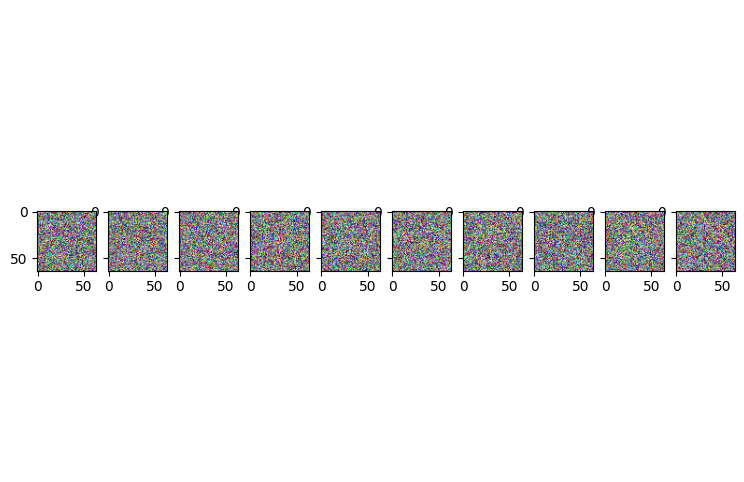

KeyboardInterrupt: 

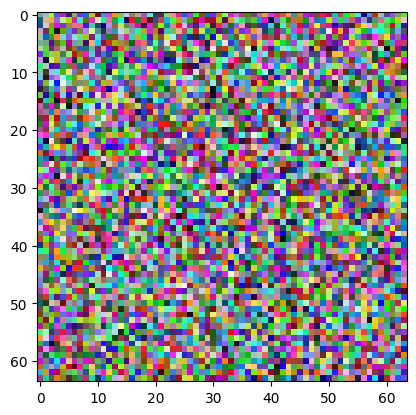

In [22]:
from torch.optim import Adam
from tensorboardX import SummaryWriter  # Import the TensorBoardX SummaryWriter
import time  # Import the time module

os.makedirs("models", exist_ok=True)

# Set device to GPU if available, otherwise fall back to CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Send the model to the selected device (GPU/CPU)
model.to(device)

# Initialize the Adam optimizer with the model parameters
optimizer = Adam(model.parameters(), lr=0.001)

# Initialize the TensorBoardX writer (this will log to the 'runs' folder by default)// http://localhost:6006/
writer = SummaryWriter()

# Number of epochs for training (adjustable)
epochs = 1000 

# Loss tracking variables
best_loss = float("inf")
last_epoch_checkpoint = None

# Start training loop
for epoch in range(epochs):
    start_time = time.time()  # Record the start time of the epoch
    model.train()  # Set model to training mode
    
    # Loop through batches in the dataloader
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()  # Reset gradients before backpropagation

        # Generate a random time step t for noise scheduling in diffusion
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

        # Calculate the loss for the batch and time step
        loss = get_loss(model, batch[0], t)  # Ensure `get_loss` is defined
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters using the optimizer

        # Log loss to TensorBoard (log every step)
        writer.add_scalar('Loss/Train', loss.item(), epoch * len(dataloader) + step)

        if(step == 0):
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
            # Generate sample images at the start of every epoch
            sample_plot_image(epoch)

    # Checkpoint saving: Save the best model based on lowest loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        print(f"Saving best model at epoch {epoch} with loss {best_loss:.4f}")
        torch.save(model.state_dict(), f"models/best_model_epoch_{epoch}.pth")

    # Optionally, save the last checkpoint
    last_epoch_checkpoint = f"models/model_epoch_last.pth"
    torch.save(model.state_dict(), last_epoch_checkpoint)

    # Calculate the time taken for the epoch and print it
    epoch_duration = time.time() - start_time  # Calculate the duration
    print(f"Epoch {epoch} took {epoch_duration:.2f} seconds")

# Close the TensorBoard writer after training
writer.close()

# Final saving of the last model after the loop ends
print(f"Saving last model at epoch {epochs - 1}")
torch.save(model.state_dict(), f"last_model_epoch_{epochs - 1}.pth")



# Step 6: Testing

Once the model is trained its time to test it and generate new fancy images

In [23]:
model = SimpleUnet().to(device)
best_model_epoch=650
model.load_state_dict(torch.load(f"models/best_model_epoch_{best_model_epoch}.pth"))
model.eval()

SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

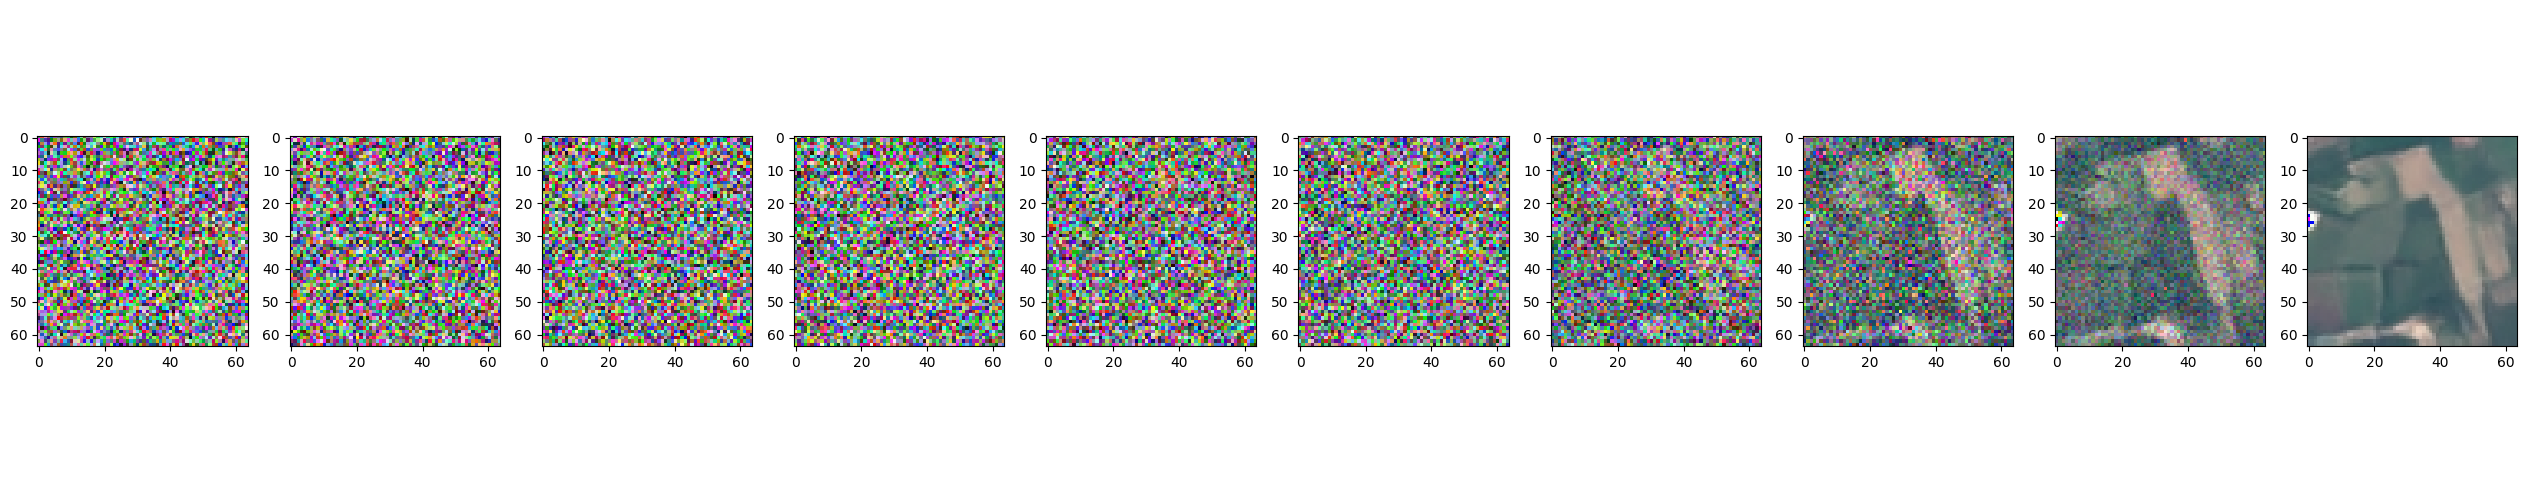

In [52]:
#Simple testing

img_size = 64
img = torch.randn((1, 3, img_size, img_size), device=device)
plt.figure(figsize=(32, 6))
plt.axis('off')
num_images = 10  # Number of intermediate images to display
stepsize = int(T / num_images)

for i in range(T-1, -1, -1):  # Reverse sampling process
    t = torch.full((1,), i, device=device, dtype=torch.long)
    img = sample_timestep(img, t)   
    if i % stepsize == 0:
        plt.subplot(1, num_images, int(num_images-i / stepsize))
        show_tensor_image(img.detach().cpu())

plt.show()

In [ ]:
@torch.no_grad()
def generate_and_save_new_image(run: int):
    """
    Generates an image by iteratively denoising a random tensor.
    Saves the least noisy image (final denoised version) in 'samples_images/'.
    
    Parameters:
    epoch (int): The current epoch number (used in the saved filename).
    """
    # Initialize a random noise image
    img_size = IMG_SIZE
    x = torch.randn((1, 3, img_size, img_size), device=device)


    for i in range(T-1, -1, -1):  # Reverse sampling process
        t = torch.full((1,), i, device=device, dtype=torch.long)
        x_new = sample_timestep(x, t)
        x = x_new
    
    # Save the fully denoised image (least noisy)
    save_path = os.path.join("images", f"imagen_{run}.png")
    
    image=x.detach().cpu()

    # Reverse transformations
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]

    img = reverse_transforms(image)
    img.save(save_path)

# Crear carpeta para guardar imágenes
output_folder = "images"
os.makedirs(output_folder, exist_ok=True)

# Generar imágenes y guardar solo la primera de cada iteración
for run in range(0,100):
    generate_and_save_new_image(run)


print("Imágenes generadas y guardadas.")

Imágenes generadas y guardadas.


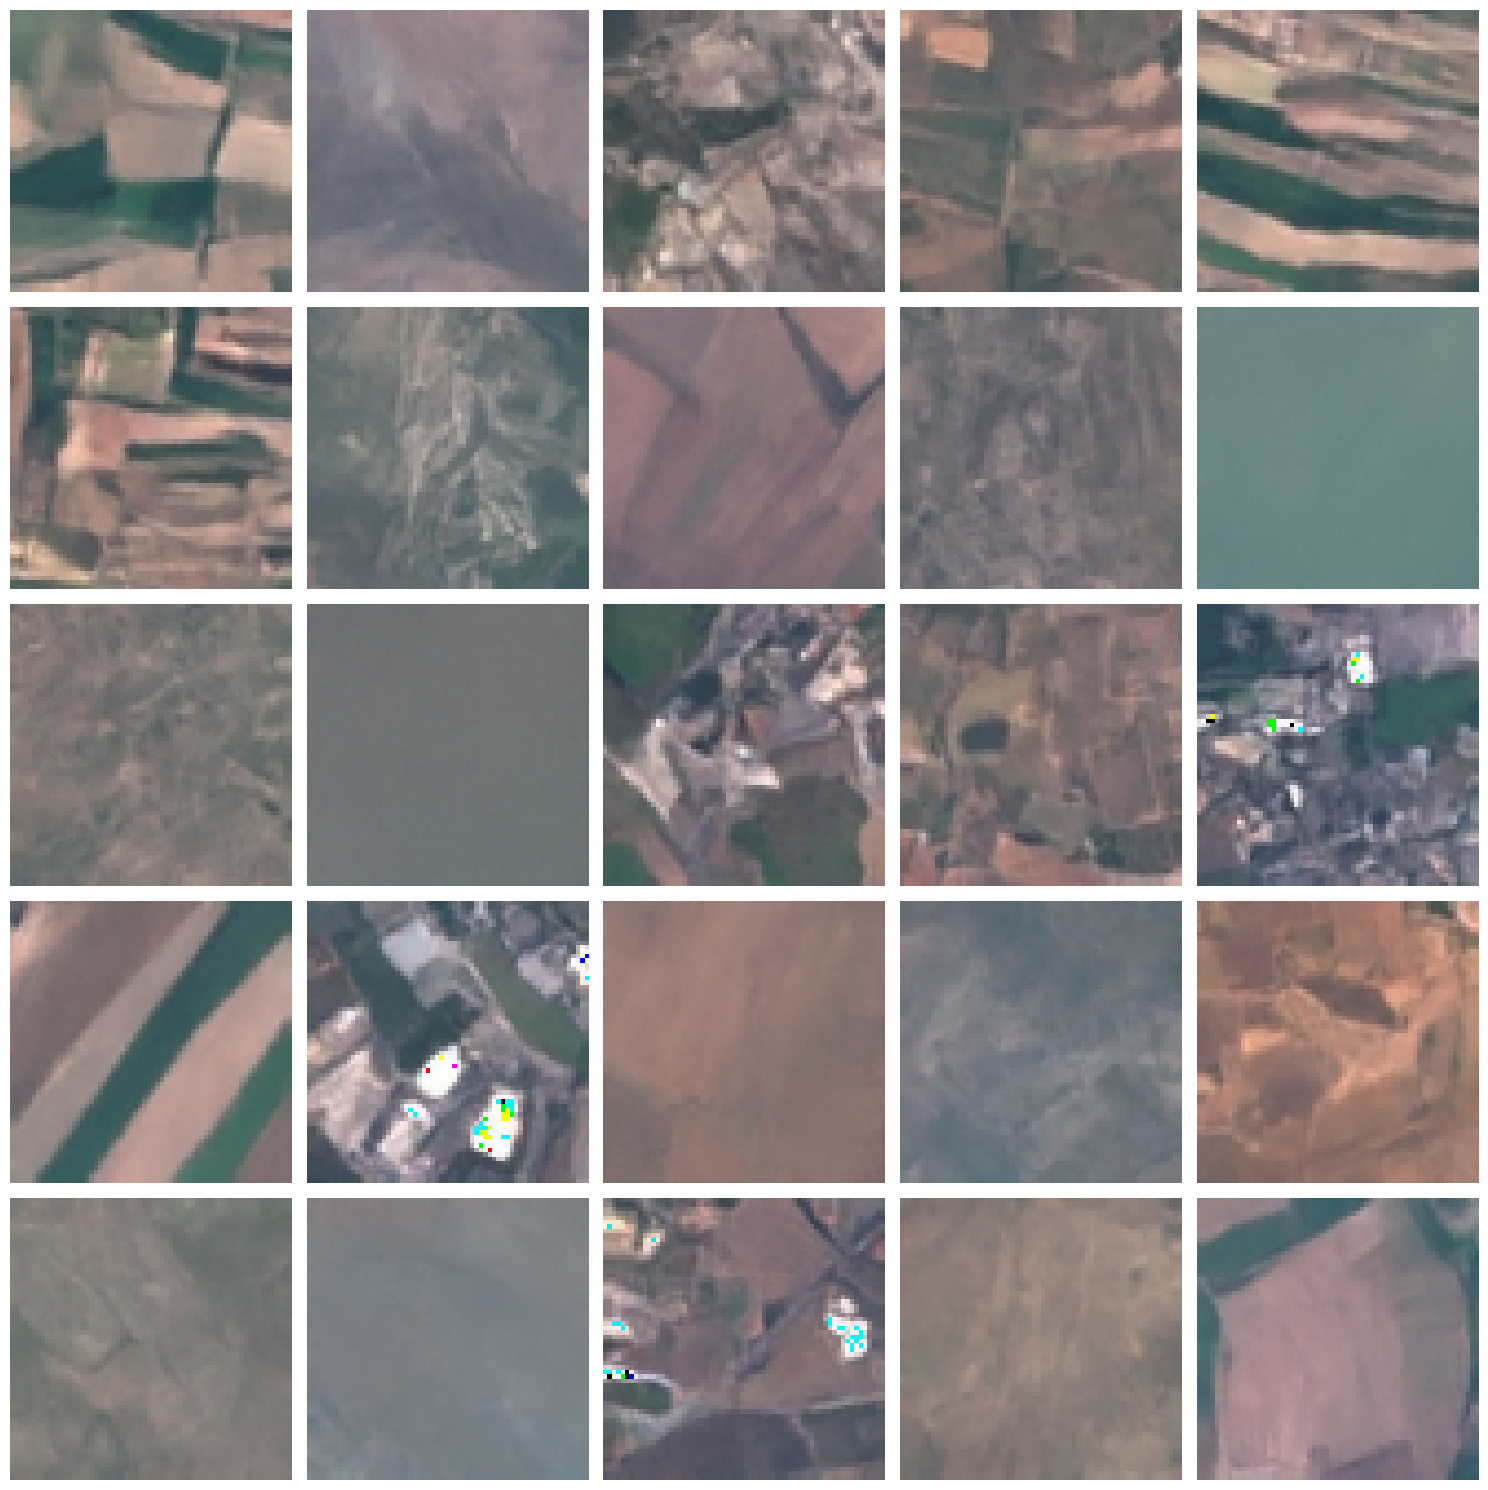

In [166]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to the folder containing images
folder_path = 'images/'

# Get the list of image files sorted by name
image_files = sorted([f for f in os.listdir(folder_path) if f.startswith('imagen_') and f.endswith('.png')])

# Read the first 25 images
images = [Image.open(os.path.join(folder_path, image_files[i])) for i in range(25)]

# Create a 5x5 mosaic
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')  # Hide axis

plt.tight_layout()
plt.show()


## Hypothetical step: Improvements

Some improvements can be made to the code.

* The main one will be to improve the functions where model is used as a global variable.
* Cosine scheduling for noise generation
* Early stopping to avoid unnecesary computation